# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
## imports here
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
import matplotlib.pyplot as plt
from collections import OrderedDict
plt.ion()
from skimage import img_as_float
import seaborn as sns
from PIL import Image

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [6]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [7]:
# TODO: Define your transforms for the training, validation, and testing sets
#data_transforms = 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# TODO: Load the datasets with ImageFolder
#image_datasets = 
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train','valid']}


# TODO: Using the image datasets and the trainforms, define the dataloaders
#dataloaders = 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train','valid']}
dataset_sizes= {x:len(image_datasets[x]) for x in ['train','valid']}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [8]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
# TODO: Build and train your network
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 102)

In [12]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 3.2623 Acc: 0.3272
valid Loss: 1.5765 Acc: 0.6663

Epoch 1/14
----------
train Loss: 1.5667 Acc: 0.6970
valid Loss: 0.7015 Acc: 0.8680

Epoch 2/14
----------
train Loss: 0.9531 Acc: 0.8210
valid Loss: 0.4106 Acc: 0.9267

Epoch 3/14
----------
train Loss: 0.7001 Acc: 0.8684
valid Loss: 0.2812 Acc: 0.9535

Epoch 4/14
----------
train Loss: 0.5575 Acc: 0.8945
valid Loss: 0.2327 Acc: 0.9548

Epoch 5/14
----------
train Loss: 0.4664 Acc: 0.9112
valid Loss: 0.2037 Acc: 0.9609

Epoch 6/14
----------
train Loss: 0.3953 Acc: 0.9205
valid Loss: 0.1679 Acc: 0.9609

Epoch 7/14
----------


KeyboardInterrupt: 

In [13]:
#### to freeze the model parameters and train just the classifier

model_conv= torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad=False

In [14]:
num_ftrs= model_conv.fc.in_features

In [15]:
model_conv.fc

Linear(in_features=512, out_features=1000, bias=True)

In [16]:
num_ftrs

512

In [17]:
fc_cc= nn.Sequential(OrderedDict([
    ('fc1',nn.Linear(num_ftrs,256)),
    ('relu',nn.ReLU()),
    ('fc2',nn.Linear(256,102)),
    ('output',nn.LogSoftmax(dim=1))
]))

In [18]:
model_conv.fc = fc_cc

In [14]:
##### model training with 15 epochs
model_conv = model_conv.to(device)
criterion=nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 3.8571 Acc: 0.1658
valid Loss: 2.1542 Acc: 0.5098

Epoch 1/14
----------
train Loss: 2.4974 Acc: 0.4016
valid Loss: 1.1844 Acc: 0.6601

Epoch 2/14
----------
train Loss: 1.8704 Acc: 0.5223
valid Loss: 0.7177 Acc: 0.8044

Epoch 3/14
----------
train Loss: 1.5841 Acc: 0.5856
valid Loss: 0.5884 Acc: 0.8191

Epoch 4/14
----------
train Loss: 1.4322 Acc: 0.6230
valid Loss: 0.5121 Acc: 0.8619

Epoch 5/14
----------
train Loss: 1.3363 Acc: 0.6335
valid Loss: 0.5248 Acc: 0.8570

Epoch 6/14
----------
train Loss: 1.2438 Acc: 0.6665
valid Loss: 0.4536 Acc: 0.8680

Epoch 7/14
----------
train Loss: 1.0436 Acc: 0.7225
valid Loss: 0.3459 Acc: 0.9095

Epoch 8/14
----------
train Loss: 0.9471 Acc: 0.7427
valid Loss: 0.3503 Acc: 0.9095

Epoch 9/14
----------
train Loss: 0.9879 Acc: 0.7363
valid Loss: 0.3384 Acc: 0.9034

Epoch 10/14
----------
train Loss: 0.9774 Acc: 0.7434
valid Loss: 0.3636 Acc: 0.9022

Epoch 11/14
----------
train Loss: 0.9563 Acc: 0.7442
valid Loss

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [15]:
# TODO: Do validation on the test set
def validation(preds,labels):
    pp_save=preds.to('cpu')
    pp_save=pp_save.numpy()
    labels= labels.to('cpu')
    labels_val = labels.numpy()
    num_correct=(pp_save==labels_val).sum()
    total_= len(labels_val)
    accuracy= num_correct/ total_
    return accuracy

In [26]:
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])
testset= datasets.ImageFolder(test_dir,transform = train_transforms)
testloader = torch.utils.data.DataLoader(testset,batch_size=25,shuffle=True)

In [17]:
### on an average accuracy is > 70 %
for inputs, labels in testloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    # zero the parameter gradients
    outputs = model_conv(inputs)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)
    val= validation(preds,labels)
    print('accuracy is {}:'.format(val),   'crossentropyloss is {}:'.format(loss) )

accuracy is 0.68: crossentropyloss is 1.1437139511108398:
accuracy is 0.88: crossentropyloss is 0.47350192070007324:
accuracy is 0.84: crossentropyloss is 0.6288959980010986:
accuracy is 0.84: crossentropyloss is 0.48107606172561646:
accuracy is 0.92: crossentropyloss is 0.3935575783252716:
accuracy is 0.76: crossentropyloss is 1.1580580472946167:
accuracy is 0.76: crossentropyloss is 0.9354409575462341:
accuracy is 0.96: crossentropyloss is 0.36861667037010193:
accuracy is 0.8: crossentropyloss is 0.8135703206062317:
accuracy is 0.8: crossentropyloss is 0.8219401836395264:
accuracy is 0.88: crossentropyloss is 0.5060104131698608:
accuracy is 0.88: crossentropyloss is 0.4412524700164795:
accuracy is 0.88: crossentropyloss is 0.48755335807800293:
accuracy is 0.84: crossentropyloss is 0.43572157621383667:
accuracy is 0.76: crossentropyloss is 1.0259145498275757:
accuracy is 0.88: crossentropyloss is 0.47293004393577576:
accuracy is 0.76: crossentropyloss is 0.9950495958328247:
accuracy i

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [18]:
model_conv.class_to_idx = image_datasets['train'].class_to_idx
model_conv.cpu()
torch.save({
    'arch':'resnet18',
    'state_dict':model_conv.state_dict(),
    'class_to_idx':model_conv.class_to_idx},
    'classifier.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [19]:
def load_model(checkpoint_path):
    chpt= torch.load(checkpoint_path)
    if chpt['arch']=='resnet18':
        model=models.resnet18(pretrained=True)
        for param in model.parameters():
            param.requires_grad=False
    else:
        print("sorry base arc not recognized")
        
    model.class_to_idx=chpt['class_to_idx']
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(512, 256)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(256, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    model.fc = classifier
    model.load_state_dict(chpt['state_dict'])
    return model

In [20]:
model=load_model('classifier.pth')

In [21]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [25]:
#from PIL import Image
#im=Image.open('flowers/test')

test_dir = data_dir + '/test'

In [42]:
im=Image.open('flowers/test/84/image_02557.jpg')

In [22]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

In [23]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [37]:
process_im_path='flowers/test/84/image_02557.jpg'

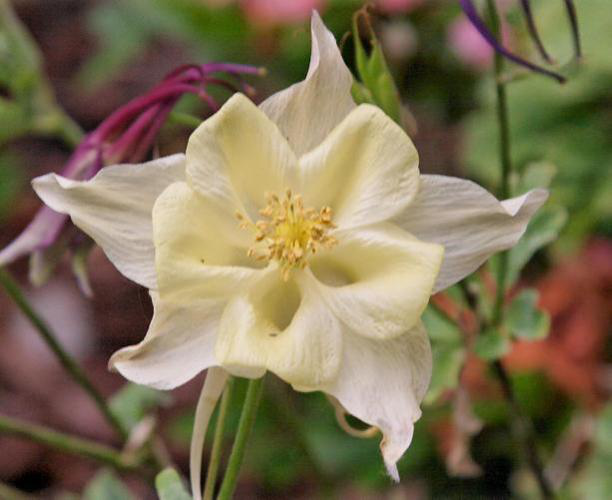

In [45]:
im

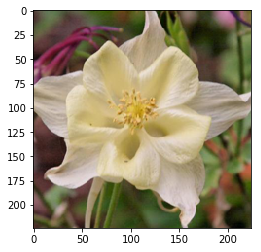

In [46]:
### transformed Image
imshow(process_image(process_im_path))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [48]:
def predict(image_path, model, top_num=5):
    # Process image
    img = process_image(image_path)
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    # Probs
    probs = torch.exp(model.forward(model_input))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [cat_to_name[idx_to_class[lab]] for lab in top_labs]
    return top_probs, top_labels, top_flowers

In [49]:
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set up title
    flower_num = image_path.split('/')[2]
    title_ = cat_to_name[flower_num]
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    # Make prediction
    probs, labs, flowers = predict(image_path, model) 
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()
    

In [51]:
image_path= 'flowers/test/84/image_02557.jpg'

In [52]:
predict(image_path,model)

([0.07371795177459717,
  0.06451937556266785,
  0.05725351721048355,
  0.0497988797724247,
  0.048026978969573975],
 ['84', '83', '53', '18', '72'],
 ['columbine', 'hibiscus', 'primula', 'peruvian lily', 'azalea'])

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

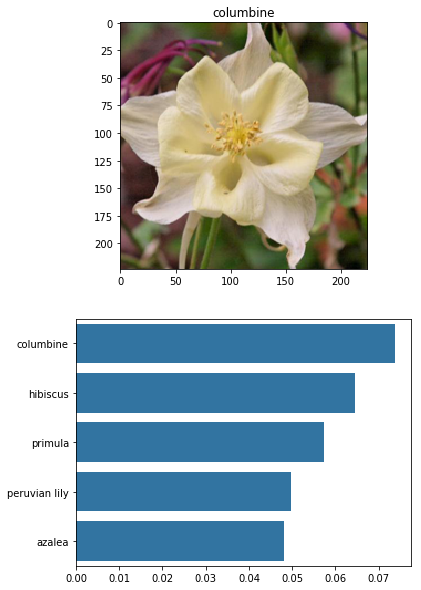

In [53]:
# TODO: Display an image along with the top 5 classes

plot_solution(image_path,model)

In [1]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook Image_classification_submission.ipynb to html',
 '[NbConvertApp] Writing 1109065 bytes to Image_classification_submission.html']